TODO: 
- Allow choice of simulator and choice betweeen Runtime or Aer
- Add resilience_level as argument      
- Change PauliSet with PauliList
- use statevector for vqe instead of qasm

In [5]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.opflow import TwoQubitReduction
from qiskit.utils import QuantumInstance
from qiskit import IBMQ, BasicAer, Aer
from qiskit.algorithms.optimizers import COBYLA
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.algorithms import VQE



def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

def get_qubit_op(coordinates):
    
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [coordinates[0],coordinates[1],0]],
            ["H", [coordinates[2],coordinates[3],0]],
            ["H", [coordinates[4],coordinates[5],0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=1,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    
    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

def calc_ground_state(op,num_part,num_orb,problem,converter,simulator='qasm', shots=1028):

    
    if simulator == 'qasm':
        backend = Aer.get_backend('qasm_simulator') 
        quantum_instance = QuantumInstance(backend,shots=shots)
        optimizer = COBYLA(maxiter=400)
    elif simulator == 'exact':
        backend = BasicAer.get_backend("statevector_simulator")
        quantum_instance = QuantumInstance(backend)
        optimizer = COBYLA(maxiter=400)
    else:
        print('Error: simulator should be qasm or exact!')
 
    result = exact_solver(problem,converter)
    
    ### 
    backend = BasicAer.get_backend("statevector_simulator")
    quantum_instance = QuantumInstance(backend)
    optimizer = COBYLA(maxiter=400)
    ###
    
    init_state = HartreeFock(num_orb, num_part, converter)
     
    var_form = UCCSD(converter,
                        num_part,
                        num_orb,
                        initial_state=init_state)

    vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance) 
    vqe_result = vqe.compute_minimum_eigenvalue(op)
    min_eng = vqe_result.eigenvalue
    final_params = vqe_result.optimal_parameters 
    vqe_ground = vqe.ansatz.bind_parameters(final_params)  
    
    print('ground state energy: ',min_eng)
    
    return vqe_ground, min_eng

In [6]:
Ha = 4.36e-18
angst = 1.0e-10
dR = 0.02 #removed the angst, since coordinates are given in angst
m = 16 #times which we calculate the force

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow.primitive_ops import PauliOp, PauliSumOp
from qiskit.quantum_info import Pauli
#from hamiltonian import calc_ground_state, get_qubit_op
import numpy as np
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit import IBMQ, BasicAer, Aer

import multiprocessing as mp
from joblib import Parallel, delayed

num_cores = mp.cpu_count()


import time #to see which part of code takes the longest


def get_psi_0(coordinates, simulator='qasm',shots=1028):

    #get qubit operator corresponding to H(R)
    (qubit_op, num_part, num_orb, problem, converter) = get_qubit_op(coordinates)
    #get the ground state of H(R)
    psi_0,_ = calc_ground_state(qubit_op,num_part, num_orb, problem, converter, simulator,shots=shots)
    psi_0 = CircuitStateFn(psi_0)

    return psi_0

def calc_forces(coordinates, psi=None, simulator='qasm'):
    
    psi_0 = psi
    
    if (psi_0 == None):
        psi_0 = get_psi_0(coordinates, simulator)
        
    if simulator == 'exact':
        backend = Aer.get_backend('qasm_simulator') 
        q_instance = QuantumInstance(backend, shots=1028)
    elif simulator == "exact":
        backend = BasicAer.get_backend("statevector_simulator")
        q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    forces = []
    vars = []
    #loop over particles
    
    for i in range(len(coordinates)):

        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(np.split((coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:]),3))
    
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(np.split((coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:]),3))
    
        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
        #define desired observable (H_+ - H_-)/(2dR) = force  
        Obs = (qubit_op_plus-qubit_op_minus)
        Obs_var = Obs*Obs
        print("PRIMITIVE LIST")
        print(Obs_var.primitive.to_list())
        nuc = rep_eng_plus - rep_eng_minus
        #Obs_squared = Obs * Obs
       
        #get the expectation value <psi_0|O|psi_0>Ã‚Â¨
        
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        measurable_expression_var = StateFn(Obs_var, is_measurement=True).compose(psi_0)
        #measurable_expression_var =  StateFn(Obs_squared, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)
        expectation_var = PauliExpectation().convert(measurable_expression_var)
 
        #expectation_var = PauliExpectation().convert(measurable_expression)
        sampler = CircuitSampler(q_instance).convert(expectation)
        sampler_var = CircuitSampler(q_instance).convert(expectation_var)
        #sampler_var = CircuitSampler(q_instance).convert(expectation) 

        f = sampler.eval().real + nuc
        ff = sampler_var.eval().real + 2*sampler.eval().real*nuc +nuc**2 +(sampler.eval().real)**2
        print(ff)
        #print(sampler_var.eval())
        #variance = sampler_var.eval().real - f^2
        forces.append(f*Ha*(1/(2*dR*angst)))
        vars.append(ff*Ha*(1/(2*dR*angst)))
        # in the dimension of nN to avoid small values.
    
    return forces,vars


def calc_force_and_cov(coordinates, simulator = 'qasm', PauliSet = None, mode = 'full', shots = 1028):
    
    
    
    if simulator == 'exact':
            backend = Aer.get_backend('qasm_simulator') 
            q_instance = QuantumInstance(backend, shots=shots)
    elif simulator == "qasm":
            backend = BasicAer.get_backend("statevector_simulator")
            q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
       
    
    '''
    ### TODO: rewrite code so that it allows choice of backend, also whether to use Aer or Runtime ###
    backend = service.backends(simulator=True)[0]
    '''
    
    num_coord = len(coordinates)   
    
    start = time.time()
    psi_0 = get_psi_0(coordinates, simulator = simulator, shots=shots)
    end = time.time()
    
    time_psi_0 = end - start

    forces = np.zeros(num_coord)
    force_ops = []
    force_op_coeffs = [] # array with dictionaries containing Pauli coefficients
    coordinates = coordinates.tolist()
    
    
    start = time.time()
    #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons) 
    for i in range(num_coord):
        
        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])

        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
        qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I^I^I) #TODO:number of I's needs to be changed according to number of qubits
        qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I^I^I)
        
       
        op =  -(qubit_op_plus - qubit_op_minus).reduce()
                    
        op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
        
        #construct dict from list
        op_dict = {}
        for (PauliString,coeff) in op_list:

            if PauliString in op_dict:
                op_dict[PauliString] += coeff
            else:
                op_dict[PauliString] = coeff
                
        force_ops.append(op)
        force_op_coeffs.append(op_dict)
        
        if i == 0:  #we need two Pauli Ops to calculate the product and their support
            P1 = op
    
    
    if PauliSet == None:
        
        pauli_op_set = {'IIII'} #Could not initialize empty set for some reason
        # construct set of PauliOp products that we need to calculate

        for PauliString,coeff in force_op_coeffs[0].items():
            pauli_op_set.add(PauliString)

        #to get set of necessary PauliOp products: 
        P_prod = P1@P1
        P_list = P_prod.primitive.to_list()

        for (PauliString,coeff) in P_list:
            pauli_op_set.add(PauliString)
                
    else: pauli_op_set = PauliSet
        
    end = time.time()
    
    time_pauli_ops = end - start
        

        # Now we calculate the expectation values of all the relevant PauliOps
    
    
    exp_dict = {} # dictionary with relevant expectation values
    
    start = time.time()
     
    for pauli_string in pauli_op_set:
        Obs = PauliOp(Pauli(pauli_string))  
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        E = sampler.eval().real     
        exp_dict[pauli_string] = E

    '''
    #Note: have taken this out of time estimate!!
    pauli_string_list = list(pauli_op_set)
    pauli_op_list = [PauliSumOp.from_list([(pauli_string,1.0)]) for pauli_string in pauli_string_list]
    
    
    
    #runtime code - way to slow
    with Session(service=service,backend=backend):
        estimator = Estimator()
        job = estimator.run(circuits=[psi_0]*len(pauli_op_list), observables=pauli_op_list,shots=shots)
        
    exp_values = job.result().values
    
    for (i,pauli_string) in enumerate(pauli_string_list):
        exp_dict[pauli_string] = exp_values[i]
    '''
                   
    for i in range(len(coordinates)):
        for pauli_op,coeff in force_op_coeffs[i].items():
            forces[i] += coeff.real*exp_dict[pauli_op]
            
    end = time.time()   
    time_calc_exp = end - start
    
    
    start = time.time()
    COV = np.zeros((num_coord,num_coord)) #force covariance matrix, without some multiplicative factors. 
        
    for i in range(num_coord):
        for j in range(i,num_coord):
            Pij = force_ops[i]@force_ops[j]
            Pij = Pij.reduce()
            Pij_list = Pij.primitive.to_list()

            #add product expectation <FiFj>
            for (pauli_string,coeff) in Pij_list:
                COV[i,j] += coeff.real*exp_dict[pauli_string]
                    #subtract <Fi><Fj>
            COV[i,j] -= forces[i]*forces[j]

            #since COV is symmetric
            if i < j:
                COV[j,i] = COV[i,j]
    end = time.time()
    
    time_cov = end - start

    print(f'Time to: Calculate Ground State - {round(time_psi_0,2)}s, Get Pauli Ops - {round(time_pauli_ops,2)}s, Calculate Pauli Expectation Values - {round(time_calc_exp,2)}s, Calculate Covariance - {round(time_cov,2)}s')
    #print(COV)
    return forces*Ha*(1/(2*dR*angst)),1/shots*COV*(Ha*(1/(2*dR*angst)))**2

In [11]:
#from Quantech.verlet_integrator import distance
#from force import calc_force_and_cov
import numpy as np
from tqdm import tqdm #to show progress


#implementation of the explicit Euler integrator
femto = 1.0e-15
angst = 1.0e-10

def distance(coordinates1,coordinates2):
    return np.sqrt(np.power((coordinates1[0] - coordinates2[0]),2) + np.power((coordinates1[1] - coordinates2[1]),2))


def main():
    #mass of particle1 (H)
    mass_0 = 1.67e-27
    #mass of particle2 (H)
    mass_1 = 1.67e-27
    #mass of particle3 (H)
    mass_2 = 1.67e-27
    #time step of integrator
    dt = 0.2*femto
    #initial velocity of atoms
    v_init_0 = np.array([0,0])
    v_init_1 = np.array([0,0])
    v_init_2 = np.array([0,0])

    v_init = np.concatenate((v_init_0,v_init_1,v_init_2),axis=None)

    #distances between atoms
    d = 0.8

    #initial positions of atoms, arrangement = equilateral triangle
    init_pos0 = np.array([0,0])
    init_pos1 = np.array([d,0])
    init_pos2 = np.array([d/2,np.sqrt(3)/2*d])
    init_pos = np.concatenate((init_pos0,init_pos1,init_pos2),axis=None)

    #integrator timesteps
    times = np.arange(0*femto, 60.0*femto, dt)
    #coordinate array
    coords = [init_pos]
    force = []
    distance01 = [d]
    distance02 = [d]
    distance12 = [d]
    #temperature in ?? 
    #k_B*T in Joule
    k_b = 1.38065e-23
    T = 420
    k_T = k_b*T
        #delta factor
    delta = 8.0*dt
    #hold v_next
    v_next = None
    
    simulator = 'qasm'

    for time in tqdm(times, desc='Progress: '):
        
        r = coords[-1]
        
        (forces,COV) = calc_force_and_cov(coords[-1],simulator = simulator, shots = 10)
        
        if time == 0:

            v_next = v_init - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.multiply(np.diagonal(COV),v_init)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)

        else:

            v_next += - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.multiply(np.diagonal(COV),v_init)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)

        dists = np.split(coords[-1],3)
        d01 = distance(dists[0],dists[1])
        print(d01)
        distance01.append(d01)
        d02 = distance(dists[0],dists[2])
        distance02.append(d02)
        d12 = distance(dists[1],dists[2])
        distance12.append(d12)
        
    return (distance01,distance02,distance12,times)    

In [12]:
import matplotlib.pyplot as plt
(distance01,distance02,distance12,times) = main()

Progress:   0%|          | 0/300 [00:00<?, ?it/s]

ground state energy:  (-3.220140304492838+0j)


Progress:   0%|          | 1/300 [00:35<2:57:36, 35.64s/it]

Time to: Calculate Ground State - 1.74s, Get Pauli Ops - 2.74s, Calculate Pauli Expectation Values - 31.12s, Calculate Covariance - 0.04s
0.8051521490776155
ground state energy:  (-3.2099257578541383+0j)


Progress:   1%|          | 2/300 [01:09<2:52:08, 34.66s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.8s, Calculate Covariance - 0.04s
0.8152380703053056
ground state energy:  (-3.190089752640474+0j)


Progress:   1%|          | 3/300 [01:44<2:51:05, 34.56s/it]

Time to: Calculate Ground State - 1.54s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 30.27s, Calculate Covariance - 0.04s
0.8298468495567658
ground state energy:  (-3.1617313578890296+0j)


Progress:   1%|▏         | 4/300 [02:17<2:49:16, 34.31s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.77s, Calculate Covariance - 0.04s
0.8484212461048244
ground state energy:  (-3.126303476558608+0j)


Progress:   2%|▏         | 5/300 [02:51<2:47:59, 34.17s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.68s, Calculate Covariance - 0.04s
0.8703111419978279
ground state energy:  (-3.0854389137535603+0j)


Progress:   2%|▏         | 6/300 [03:25<2:47:10, 34.12s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.75s, Calculate Covariance - 0.04s
0.8948248851685651
ground state energy:  (-3.0407896873522393+0j)


Progress:   2%|▏         | 7/300 [03:59<2:46:17, 34.05s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.74s, Calculate Covariance - 0.04s
0.921274067833902
ground state energy:  (-2.993898981111643+0j)


Progress:   3%|▎         | 8/300 [04:33<2:45:21, 33.98s/it]

Time to: Calculate Ground State - 1.49s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.69s, Calculate Covariance - 0.04s
0.9490041930354818
ground state energy:  (-2.9461236230210557+0j)


Progress:   3%|▎         | 9/300 [05:07<2:44:50, 33.99s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.8s, Calculate Covariance - 0.04s
0.977415594104732
ground state energy:  (-2.8985957337833743+0j)


Progress:   3%|▎         | 10/300 [05:41<2:44:28, 34.03s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.78s, Calculate Covariance - 0.04s
1.0059722847513195
ground state energy:  (-2.8522215761479845+0j)


Progress:   4%|▎         | 11/300 [06:15<2:43:33, 33.96s/it]

Time to: Calculate Ground State - 1.48s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.66s, Calculate Covariance - 0.04s
1.034205139357032
ground state energy:  (-2.8076986732710667+0j)


Progress:   4%|▍         | 12/300 [06:49<2:43:04, 33.97s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.74s, Calculate Covariance - 0.04s
1.0617096238636055
ground state energy:  (-2.76554470670808+0j)


Progress:   4%|▍         | 13/300 [07:23<2:42:22, 33.94s/it]

Time to: Calculate Ground State - 1.52s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.73s, Calculate Covariance - 0.04s
1.088141731405826
ground state energy:  (-2.7261284548151243+0j)


Progress:   5%|▍         | 14/300 [07:57<2:42:00, 33.99s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.76s, Calculate Covariance - 0.04s
1.1132116981841567
ground state energy:  (-2.689700816908516+0j)


Progress:   5%|▌         | 15/300 [08:31<2:41:36, 34.02s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.72s, Calculate Covariance - 0.04s
1.1366774884431468
ground state energy:  (-2.6564219756211513+0j)


Progress:   5%|▌         | 16/300 [09:05<2:40:59, 34.01s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.65s, Calculate Covariance - 0.04s
1.15833884780279
ground state energy:  (-2.6263839233362742+0j)


Progress:   6%|▌         | 17/300 [09:39<2:40:14, 33.97s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.62s, Calculate Covariance - 0.04s
1.1780313949813772
ground state energy:  (-2.5996293344552384+0j)


Progress:   6%|▌         | 18/300 [10:13<2:39:57, 34.04s/it]

Time to: Calculate Ground State - 1.78s, Get Pauli Ops - 2.56s, Calculate Pauli Expectation Values - 29.81s, Calculate Covariance - 0.04s
1.195621456937317
ground state energy:  (-2.576166557872239+0j)


Progress:   6%|▋         | 19/300 [10:47<2:39:20, 34.02s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.55s, Calculate Pauli Expectation Values - 29.72s, Calculate Covariance - 0.04s
1.211000991589456
ground state energy:  (-2.555982214582993+0j)


Progress:   7%|▋         | 20/300 [11:21<2:38:43, 34.01s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.73s, Calculate Covariance - 0.04s
1.224084197157929
ground state energy:  (-2.5390497115589787+0j)


Progress:   7%|▋         | 21/300 [11:57<2:41:12, 34.67s/it]

Time to: Calculate Ground State - 1.78s, Get Pauli Ops - 2.88s, Calculate Pauli Expectation Values - 31.5s, Calculate Covariance - 0.04s
1.2348039585234258
ground state energy:  (-2.5253368514037797+0j)


Progress:   7%|▋         | 22/300 [12:31<2:39:42, 34.47s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.75s, Calculate Covariance - 0.04s
1.2431091436567177
ground state energy:  (-2.514811174821577+0j)


Progress:   8%|▊         | 23/300 [13:05<2:38:24, 34.31s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.6s, Calculate Covariance - 0.04s
1.2489628353993962
ground state energy:  (-2.507443630235023+0j)


Progress:   8%|▊         | 24/300 [13:39<2:37:04, 34.15s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.59s, Calculate Covariance - 0.04s
1.252339485587321
ground state energy:  (-2.5032128598198446+0j)


Progress:   8%|▊         | 25/300 [14:13<2:36:14, 34.09s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.63s, Calculate Covariance - 0.04s
1.2532250075163365
ground state energy:  (-2.502105656931135+0j)


Progress:   9%|▊         | 26/300 [14:47<2:35:24, 34.03s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.67s, Calculate Covariance - 0.04s
1.2516160792181241
ground state energy:  (-2.504118118267818+0j)


Progress:   9%|▉         | 27/300 [15:21<2:34:47, 34.02s/it]

Time to: Calculate Ground State - 1.73s, Get Pauli Ops - 2.57s, Calculate Pauli Expectation Values - 29.65s, Calculate Covariance - 0.04s
1.2475191215187866
ground state energy:  (-2.5092568799667125+0j)


Progress:   9%|▉         | 28/300 [15:55<2:34:39, 34.11s/it]

Time to: Calculate Ground State - 1.83s, Get Pauli Ops - 2.81s, Calculate Pauli Expectation Values - 29.65s, Calculate Covariance - 0.04s
1.2409512864842869
ground state energy:  (-2.5175378676285485+0j)


Progress:  10%|▉         | 29/300 [16:29<2:33:54, 34.07s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.66s, Calculate Covariance - 0.04s
1.2319408202473472
ground state energy:  (-2.528985484889122+0j)


Progress:  10%|█         | 30/300 [17:04<2:33:43, 34.16s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.57s, Calculate Pauli Expectation Values - 30.15s, Calculate Covariance - 0.04s
1.220529170487708
ground state energy:  (-2.543629413439256+0j)


Progress:  10%|█         | 31/300 [17:40<2:35:49, 34.76s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 31.87s, Calculate Covariance - 0.04s
1.2067719057031066
ground state energy:  (-2.5615024126426236+0j)


Progress:  11%|█         | 32/300 [18:14<2:34:48, 34.66s/it]

Time to: Calculate Ground State - 1.74s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 30.08s, Calculate Covariance - 0.04s
1.1907412041537033
ground state energy:  (-2.5826357652372582+0j)


Progress:  11%|█         | 33/300 [18:50<2:35:42, 34.99s/it]

Time to: Calculate Ground State - 1.76s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 31.38s, Calculate Covariance - 0.04s
1.1725287496263113
ground state energy:  (-2.607053314133963+0j)


Progress:  11%|█▏        | 34/300 [19:26<2:36:00, 35.19s/it]

Time to: Calculate Ground State - 1.98s, Get Pauli Ops - 2.78s, Calculate Pauli Expectation Values - 30.86s, Calculate Covariance - 0.04s
1.1522496332452652
ground state energy:  (-2.6347631704868104+0j)


Progress:  12%|█▏        | 35/300 [20:00<2:34:35, 35.00s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 30.31s, Calculate Covariance - 0.04s
1.1300459186850267
ground state energy:  (-2.665748394452985+0j)


Progress:  12%|█▏        | 36/300 [20:35<2:33:38, 34.92s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 2.68s, Calculate Pauli Expectation Values - 30.29s, Calculate Covariance - 0.04s
1.1060919694193903
ground state energy:  (-2.699953541932511+0j)


Progress:  12%|█▏        | 37/300 [21:10<2:32:50, 34.87s/it]

Time to: Calculate Ground State - 1.74s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.34s, Calculate Covariance - 0.04s
1.080599482448381
ground state energy:  (-2.737269015407104+0j)


Progress:  13%|█▎        | 38/300 [21:44<2:31:23, 34.67s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.96s, Calculate Covariance - 0.04s
1.05382379587463
ground state energy:  (-2.777510695901778+0j)


Progress:  13%|█▎        | 39/300 [22:18<2:30:11, 34.53s/it]

Time to: Calculate Ground State - 1.51s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 30.04s, Calculate Covariance - 0.04s
1.0260700071728286
ground state energy:  (-2.820396044881452+0j)


Progress:  13%|█▎        | 40/300 [22:52<2:29:06, 34.41s/it]

Time to: Calculate Ground State - 1.47s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 30.03s, Calculate Covariance - 0.04s
0.9976988193113705
ground state energy:  (-2.8655167827400096+0j)


Progress:  14%|█▎        | 41/300 [23:27<2:28:32, 34.41s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.84s, Calculate Pauli Expectation Values - 29.94s, Calculate Covariance - 0.04s
0.9691331680885605
ground state energy:  (-2.9123061348355552+0j)


Progress:  14%|█▍        | 42/300 [24:01<2:28:05, 34.44s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.7s, Calculate Pauli Expectation Values - 30.09s, Calculate Covariance - 0.04s
0.9408617424672008
ground state energy:  (-2.9600083678166644+0j)


Progress:  14%|█▍        | 43/300 [24:35<2:27:13, 34.37s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.98s, Calculate Covariance - 0.04s
0.9134392758616442
ground state energy:  (-3.0076531894430873+0j)


Progress:  15%|█▍        | 44/300 [25:10<2:26:34, 34.35s/it]

Time to: Calculate Ground State - 1.73s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.89s, Calculate Covariance - 0.04s
0.8874828732108093
ground state energy:  (-3.0540415322878705+0j)


Progress:  15%|█▌        | 45/300 [25:44<2:25:40, 34.28s/it]

Time to: Calculate Ground State - 1.5s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.93s, Calculate Covariance - 0.04s
0.8636592563671891
ground state energy:  (-3.0977572568553744+0j)


Progress:  15%|█▌        | 46/300 [26:18<2:25:03, 34.27s/it]

Time to: Calculate Ground State - 1.51s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 30.08s, Calculate Covariance - 0.04s
0.8426611947568909
ground state energy:  (-3.137216126082949+0j)


Progress:  16%|█▌        | 47/300 [26:52<2:24:30, 34.27s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.93s, Calculate Covariance - 0.04s
0.8251733595716434
ground state energy:  (-3.1707566180227333+0j)


Progress:  16%|█▌        | 48/300 [27:26<2:23:49, 34.24s/it]

Time to: Calculate Ground State - 1.51s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 30.03s, Calculate Covariance - 0.04s
0.8118252537182797
ground state energy:  (-3.1967788981106717+0j)


Progress:  16%|█▋        | 49/300 [28:01<2:23:07, 34.21s/it]

Time to: Calculate Ground State - 1.46s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.02s, Calculate Covariance - 0.04s
0.8031371791495981
ground state energy:  (-3.213914758079325+0j)


Progress:  17%|█▋        | 50/300 [28:35<2:22:33, 34.21s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.93s, Calculate Covariance - 0.04s
0.7994672792711165
ground state energy:  (-3.2212003549467814+0j)


Progress:  17%|█▋        | 51/300 [29:09<2:22:02, 34.22s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.91s, Calculate Covariance - 0.04s
0.8009722814722511
ground state energy:  (-3.218209069112655+0j)


Progress:  17%|█▋        | 52/300 [29:45<2:23:46, 34.78s/it]

Time to: Calculate Ground State - 1.52s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 33.2s, Calculate Covariance - 0.04s
0.8075874792066311
ground state energy:  (-3.205117374009999+0j)


Progress:  18%|█▊        | 53/300 [30:20<2:23:39, 34.90s/it]

Time to: Calculate Ground State - 1.86s, Get Pauli Ops - 3.05s, Calculate Pauli Expectation Values - 30.22s, Calculate Covariance - 0.04s
0.8190351457194484
ground state energy:  (-3.182677133164024+0j)


Progress:  18%|█▊        | 54/300 [30:54<2:21:59, 34.63s/it]

Time to: Calculate Ground State - 1.52s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.84s, Calculate Covariance - 0.04s
0.8348569285174878
ground state energy:  (-3.1521068870169+0j)


Progress:  18%|█▊        | 55/300 [31:28<2:20:32, 34.42s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.69s, Calculate Covariance - 0.04s
0.8544628981953957
ground state energy:  (-3.1149299333237286+0j)


Progress:  19%|█▊        | 56/300 [32:02<2:19:24, 34.28s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 29.71s, Calculate Covariance - 0.04s
0.8771852922940748
ground state energy:  (-3.072801066258073+0j)


Progress:  19%|█▉        | 57/300 [32:36<2:18:27, 34.19s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.8s, Calculate Covariance - 0.04s
0.9023296046645278
ground state energy:  (-3.0273512191861194+0j)


Progress:  19%|█▉        | 58/300 [33:10<2:17:29, 34.09s/it]

Time to: Calculate Ground State - 1.46s, Get Pauli Ops - 2.57s, Calculate Pauli Expectation Values - 29.78s, Calculate Covariance - 0.04s
0.9292149293646791
ground state energy:  (-2.98007495588775+0j)


Progress:  20%|█▉        | 59/300 [33:44<2:16:46, 34.05s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.8s, Calculate Covariance - 0.04s
0.9572010293282639
ground state energy:  (-2.93226611500271+0j)


Progress:  20%|██        | 60/300 [34:18<2:16:10, 34.05s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.84s, Calculate Covariance - 0.04s
0.9857059943468478
ground state energy:  (-2.8849905548184878+0j)


Progress:  20%|██        | 61/300 [34:52<2:15:20, 33.98s/it]

Time to: Calculate Ground State - 1.44s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.74s, Calculate Covariance - 0.04s
1.0142134332905697
ground state energy:  (-2.8390911533583183+0j)


Progress:  21%|██        | 62/300 [35:26<2:14:57, 34.02s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.57s, Calculate Pauli Expectation Values - 29.92s, Calculate Covariance - 0.04s
1.0422730762155081
ground state energy:  (-2.795210432657842+0j)


Progress:  21%|██        | 63/300 [36:00<2:14:20, 34.01s/it]

Time to: Calculate Ground State - 1.49s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.86s, Calculate Covariance - 0.04s
1.069498672485682
ground state energy:  (-2.7538193409985583+0j)


Progress:  21%|██▏       | 64/300 [36:34<2:13:59, 34.06s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.8s, Calculate Covariance - 0.04s
1.0955625418239938
ground state energy:  (-2.7152495627528728+0j)


Progress:  22%|██▏       | 65/300 [37:08<2:13:39, 34.12s/it]

Time to: Calculate Ground State - 1.75s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.87s, Calculate Covariance - 0.04s
1.1201895574191707
ground state energy:  (-2.6797228839251734+0j)


Progress:  22%|██▏       | 66/300 [37:43<2:13:04, 34.12s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.77s, Calculate Covariance - 0.04s
1.1431500188068404
ground state energy:  (-2.6473781376851866+0j)


Progress:  22%|██▏       | 67/300 [38:17<2:12:34, 34.14s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.88s, Calculate Covariance - 0.04s
1.164254811359377
ground state energy:  (-2.618291017065462+0j)


Progress:  23%|██▎       | 68/300 [38:51<2:11:56, 34.12s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.57s, Calculate Pauli Expectation Values - 29.78s, Calculate Covariance - 0.04s
1.1833489768940753
ground state energy:  (-2.5924928243104204+0j)


Progress:  23%|██▎       | 69/300 [39:25<2:11:20, 34.11s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.76s, Calculate Covariance - 0.04s
1.200306489609461
ground state energy:  (-2.569984809870564+0j)


Progress:  23%|██▎       | 70/300 [39:59<2:10:42, 34.10s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.56s, Calculate Pauli Expectation Values - 29.89s, Calculate Covariance - 0.04s
1.2150262917660386
ground state energy:  (-2.5507486875781242+0j)


Progress:  24%|██▎       | 71/300 [40:39<2:17:29, 36.02s/it]

Time to: Calculate Ground State - 1.5s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 33.51s, Calculate Covariance - 0.04s
1.2274288619625233
ground state energy:  (-2.534754919334833+0j)


Progress:  24%|██▍       | 72/300 [44:29<5:57:26, 94.07s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.56s, Calculate Pauli Expectation Values - 30.2s, Calculate Covariance - 0.04s
1.2374517598640258
ground state energy:  (-2.5219710061411282+0j)


Progress:  24%|██▍       | 73/300 [1:02:02<24:03:53, 381.64s/it]

Time to: Calculate Ground State - 1.88s, Get Pauli Ops - 2.69s, Calculate Pauli Expectation Values - 34.92s, Calculate Covariance - 0.04s
1.2450479421101805
ground state energy:  (-2.5123654256114247+0j)


Progress:  25%|██▍       | 74/300 [1:02:36<17:24:51, 277.40s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.76s, Calculate Covariance - 0.04s
1.2501834024373781
ground state energy:  (-2.505911790579309+0j)


Progress:  25%|██▌       | 75/300 [1:08:10<18:23:53, 294.37s/it]

Time to: Calculate Ground State - 1.82s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 32.9s, Calculate Covariance - 0.04s
1.2528364994902106
ground state energy:  (-2.502590347176759+0j)


Progress:  25%|██▌       | 76/300 [1:08:46<13:29:45, 216.90s/it]

Time to: Calculate Ground State - 1.96s, Get Pauli Ops - 2.91s, Calculate Pauli Expectation Values - 31.22s, Calculate Covariance - 0.04s
1.2529965421288487
ground state energy:  (-2.5023902455495626+0j)


Progress:  26%|██▌       | 77/300 [1:09:21<10:03:57, 162.50s/it]

Time to: Calculate Ground State - 1.87s, Get Pauli Ops - 2.53s, Calculate Pauli Expectation Values - 31.11s, Calculate Covariance - 0.05s
1.2506625930584214
ground state energy:  (-2.50531118318001+0j)


Progress:  26%|██▌       | 78/300 [1:09:57<7:39:50, 124.28s/it] 

Time to: Calculate Ground State - 1.82s, Get Pauli Ops - 2.68s, Calculate Pauli Expectation Values - 30.56s, Calculate Covariance - 0.04s
1.2458447676676232
ground state energy:  (-2.511361838206282+0j)


Progress:  26%|██▋       | 79/300 [1:10:30<5:57:47, 97.14s/it] 

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.54s, Calculate Pauli Expectation Values - 29.53s, Calculate Covariance - 0.04s
1.2385633191616123
ground state energy:  (-2.520560776808254+0j)


Progress:  27%|██▋       | 80/300 [1:11:04<4:46:46, 78.21s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.56s, Calculate Pauli Expectation Values - 29.74s, Calculate Covariance - 0.04s
1.2288503437764433
ground state energy:  (-2.5329339971849194+0j)


Progress:  27%|██▋       | 81/300 [1:11:38<3:56:40, 64.84s/it]

Time to: Calculate Ground State - 1.52s, Get Pauli Ops - 2.55s, Calculate Pauli Expectation Values - 29.53s, Calculate Covariance - 0.04s
1.2167505155948863
ground state energy:  (-2.548513286379326+0j)


Progress:  27%|██▋       | 82/300 [1:12:12<3:21:46, 55.53s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.57s, Calculate Pauli Expectation Values - 29.62s, Calculate Covariance - 0.04s
1.2023244545549958
ground state energy:  (-2.567330908068227+0j)


Progress:  28%|██▊       | 83/300 [1:12:46<2:57:17, 49.02s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.55s, Calculate Pauli Expectation Values - 29.66s, Calculate Covariance - 0.04s
1.1856493885763246
ground state energy:  (-2.5894169997547536+0j)


Progress:  28%|██▊       | 84/300 [1:13:20<2:40:22, 44.55s/it]

Time to: Calculate Ground State - 1.73s, Get Pauli Ops - 2.57s, Calculate Pauli Expectation Values - 29.78s, Calculate Covariance - 0.04s
1.1668237392099228
ground state energy:  (-2.614791307910477+0j)


Progress:  28%|██▊       | 85/300 [1:13:54<2:28:17, 41.38s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.56s, Calculate Pauli Expectation Values - 29.81s, Calculate Covariance - 0.04s
1.1459697550404
ground state energy:  (-2.6434561113834567+0j)


Progress:  29%|██▊       | 86/300 [1:14:28<2:19:49, 39.21s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.76s, Calculate Covariance - 0.04s
1.1232383308906937
ground state energy:  (-2.6753847571542786+0j)


Progress:  29%|██▉       | 87/300 [1:15:02<2:13:28, 37.60s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.6s, Calculate Covariance - 0.04s
1.0988145279535861
ground state energy:  (-2.710507254768629+0j)


Progress:  29%|██▉       | 88/300 [1:15:36<2:09:07, 36.54s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.8s, Calculate Covariance - 0.04s
1.0729215542816406
ground state energy:  (-2.748695330900344+0j)


Progress:  30%|██▉       | 89/300 [1:16:10<2:05:44, 35.76s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.68s, Calculate Covariance - 0.04s
1.0458283124831405
ground state energy:  (-2.789739312444987+0j)


Progress:  30%|███       | 90/300 [1:16:44<2:03:18, 35.23s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.82s, Calculate Covariance - 0.04s
1.0178556323069923
ground state energy:  (-2.8333228868783586+0j)


Progress:  30%|███       | 91/300 [1:17:18<2:01:17, 34.82s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.63s, Calculate Covariance - 0.04s
0.989382186837426
ground state energy:  (-2.8789942856217148+0j)


Progress:  31%|███       | 92/300 [1:17:52<2:00:00, 34.62s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.81s, Calculate Covariance - 0.04s
0.9608494618535144
ground state energy:  (-2.926135387964746+0j)


Progress:  31%|███       | 93/300 [1:18:26<1:58:31, 34.36s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.53s, Calculate Covariance - 0.04s
0.932765858368819
ground state energy:  (-2.9739296437445377+0j)


Progress:  31%|███▏      | 94/300 [1:18:59<1:57:33, 34.24s/it]

Time to: Calculate Ground State - 1.81s, Get Pauli Ops - 2.57s, Calculate Pauli Expectation Values - 29.54s, Calculate Covariance - 0.04s
0.9057050443678781
ground state energy:  (-3.021340609375809+0j)


Progress:  32%|███▏      | 95/300 [1:19:33<1:56:39, 34.14s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.69s, Calculate Covariance - 0.04s
0.8802998983102817
ground state energy:  (-3.0671041260705314+0j)


Progress:  32%|███▏      | 96/300 [1:20:12<2:00:10, 35.35s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 33.21s, Calculate Covariance - 0.04s
0.857228065984443
ground state energy:  (-3.1097475269936834+0j)


Progress:  32%|███▏      | 97/300 [1:20:45<1:57:58, 34.87s/it]

Time to: Calculate Ground State - 1.5s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.66s, Calculate Covariance - 0.04s
0.8371838824713366
ground state energy:  (-3.147652818976358+0j)


Progress:  33%|███▎      | 98/300 [1:37:39<18:25:32, 328.38s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 3.17s, Calculate Pauli Expectation Values - 29.62s, Calculate Covariance - 0.04s
0.8208408475686384
ground state energy:  (-3.1791611568265816+0j)


Progress:  33%|███▎      | 99/300 [1:54:51<30:07:46, 539.64s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 30.62s, Calculate Covariance - 0.04s
0.808802063037241
ground state energy:  (-3.202722517421857+0j)


Progress:  33%|███▎      | 100/300 [2:01:51<27:59:27, 503.84s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 30.17s, Calculate Covariance - 0.04s
0.8015455490331322
ground state energy:  (-3.2170699255538526+0j)


Progress:  34%|███▎      | 101/300 [2:02:27<20:05:02, 363.33s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.72s, Calculate Pauli Expectation Values - 31.03s, Calculate Covariance - 0.04s
0.7993743272697474
ground state energy:  (-3.2213843278066494+0j)


Progress:  34%|███▍      | 102/300 [2:03:03<14:34:36, 265.03s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.91s, Calculate Pauli Expectation Values - 31.01s, Calculate Covariance - 0.04s
0.8023816875523935
ground state energy:  (-3.2154114525910606+0j)


Progress:  34%|███▍      | 103/300 [2:03:39<10:44:39, 196.34s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 31.82s, Calculate Covariance - 0.04s
0.810439673071514
ground state energy:  (-3.1995005158410827+0j)


Progress:  35%|███▍      | 104/300 [2:04:13<8:02:34, 147.73s/it] 

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.93s, Calculate Covariance - 0.04s
0.8232133803824198
ground state energy:  (-3.17455406531192+0j)


Progress:  35%|███▌      | 105/300 [2:04:47<6:09:16, 113.62s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.7s, Calculate Covariance - 0.04s
0.840200788673683
ground state energy:  (-3.1418970531110446+0j)


Progress:  35%|███▌      | 106/300 [2:05:21<4:50:04, 89.71s/it] 

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.69s, Calculate Covariance - 0.04s
0.8607836070051543
ground state energy:  (-3.1031089113427677+0j)


Progress:  36%|███▌      | 107/300 [2:05:55<3:54:53, 73.02s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.71s, Calculate Covariance - 0.04s
0.884281395020448
ground state energy:  (-3.059851873423081+0j)


Progress:  36%|███▌      | 108/300 [2:06:29<3:16:22, 61.37s/it]

Time to: Calculate Ground State - 1.52s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.98s, Calculate Covariance - 0.04s
0.9100000670716099
ground state energy:  (-3.013726540610593+0j)


Progress:  36%|███▋      | 109/300 [2:07:03<2:49:14, 53.16s/it]

Time to: Calculate Ground State - 1.75s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.59s, Calculate Covariance - 0.04s
0.9372683582427006
ground state energy:  (-2.966173595869174+0j)


Progress:  37%|███▋      | 110/300 [2:07:37<2:29:59, 47.37s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.61s, Calculate Covariance - 0.04s
0.9654617490395409
ground state energy:  (-2.9184216093200326+0j)


Progress:  37%|███▋      | 111/300 [2:08:12<2:17:21, 43.61s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.88s, Calculate Pauli Expectation Values - 30.37s, Calculate Covariance - 0.04s
0.9940169052068435
ground state energy:  (-2.8714702460085544+0j)


Progress:  37%|███▋      | 112/300 [2:08:47<2:08:24, 40.98s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.79s, Calculate Pauli Expectation Values - 30.45s, Calculate Covariance - 0.04s
1.0224370666995561
ground state energy:  (-2.8261008562015073+0j)


Progress:  38%|███▊      | 113/300 [2:09:21<2:01:05, 38.85s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.71s, Calculate Pauli Expectation Values - 29.59s, Calculate Covariance - 0.04s
1.0502911006888156
ground state energy:  (-2.782902680594986+0j)


Progress:  38%|███▊      | 114/300 [2:09:56<1:56:47, 37.68s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.68s, Calculate Covariance - 0.04s
1.0772099674622837
ground state energy:  (-2.7423036756939414+0j)


Progress:  38%|███▊      | 115/300 [2:10:30<1:53:12, 36.71s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 30.22s, Calculate Covariance - 0.04s
1.1028817263734354
ground state energy:  (-2.7046008821083607+0j)


Progress:  39%|███▊      | 116/300 [2:11:04<1:50:11, 35.93s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.79s, Calculate Covariance - 0.04s
1.127045596430338
ground state energy:  (-2.669988803618267+0j)


Progress:  39%|███▉      | 117/300 [2:11:38<1:48:00, 35.41s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.88s, Calculate Covariance - 0.04s
1.149484506980038
ground state energy:  (-2.6385855871345365+0j)


Progress:  39%|███▉      | 118/300 [2:12:13<1:46:20, 35.06s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.88s, Calculate Covariance - 0.04s
1.1700195555051978
ground state energy:  (-2.610452791202198+0j)


Progress:  40%|███▉      | 119/300 [2:12:47<1:45:00, 34.81s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.92s, Calculate Covariance - 0.04s
1.188504709750546
ground state energy:  (-2.585611649750501+0j)


Progress:  40%|████      | 120/300 [2:13:21<1:43:33, 34.52s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.57s, Calculate Covariance - 0.04s
1.204822092667706
ground state energy:  (-2.564056115907708+0j)


Progress:  40%|████      | 121/300 [2:13:54<1:42:18, 34.29s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.56s, Calculate Pauli Expectation Values - 29.61s, Calculate Covariance - 0.04s
1.2188765355135809
ground state energy:  (-2.545764804273459+0j)


Progress:  41%|████      | 122/300 [2:14:29<1:41:38, 34.26s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.94s, Calculate Covariance - 0.04s
1.230593651261851
ground state energy:  (-2.5307068528384686+0j)


Progress:  41%|████      | 123/300 [2:15:02<1:40:44, 34.15s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.57s, Calculate Pauli Expectation Values - 29.62s, Calculate Covariance - 0.04s
1.23991587205854
ground state energy:  (-2.518849385902592+0j)


Progress:  41%|████▏     | 124/300 [2:15:36<1:39:59, 34.09s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.53s, Calculate Pauli Expectation Values - 29.74s, Calculate Covariance - 0.04s
1.246800433000769
ground state energy:  (-2.510161656537962+0j)


Progress:  42%|████▏     | 125/300 [2:16:10<1:39:12, 34.01s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 2.55s, Calculate Pauli Expectation Values - 29.54s, Calculate Covariance - 0.04s
1.2512170656872432
ground state energy:  (-2.5046189737757905+0j)


Progress:  42%|████▏     | 126/300 [2:16:44<1:38:26, 33.95s/it]

Time to: Calculate Ground State - 1.77s, Get Pauli Ops - 2.53s, Calculate Pauli Expectation Values - 29.46s, Calculate Covariance - 0.04s
1.253147121720187
ground state energy:  (-2.502204349592333+0j)


Progress:  42%|████▏     | 127/300 [2:17:19<1:38:45, 34.25s/it]

Time to: Calculate Ground State - 1.73s, Get Pauli Ops - 2.53s, Calculate Pauli Expectation Values - 30.66s, Calculate Covariance - 0.04s
1.2525826425078734
ground state energy:  (-2.5029101341132476+0j)


Progress:  43%|████▎     | 128/300 [2:17:54<1:38:46, 34.46s/it]

Time to: Calculate Ground State - 1.76s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.52s, Calculate Covariance - 0.04s
1.2495260696816368
ground state energy:  (-2.506738408065284+0j)


Progress:  43%|████▎     | 129/300 [2:18:28<1:37:57, 34.37s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.69s, Calculate Pauli Expectation Values - 29.89s, Calculate Covariance - 0.04s
1.2439901146300523
ground state energy:  (-2.513701187084843+0j)


Progress:  43%|████▎     | 130/300 [2:19:02<1:36:58, 34.23s/it]

Time to: Calculate Ground State - 1.74s, Get Pauli Ops - 2.54s, Calculate Pauli Expectation Values - 29.56s, Calculate Covariance - 0.04s
1.2359985216209084
ground state energy:  (-2.523819208341731+0j)


Progress:  44%|████▎     | 131/300 [2:19:36<1:36:09, 34.14s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.55s, Calculate Pauli Expectation Values - 29.74s, Calculate Covariance - 0.04s
1.2255870570034963
ground state energy:  (-2.537120172344039+0j)


Progress:  44%|████▍     | 132/300 [2:20:10<1:35:41, 34.18s/it]

Time to: Calculate Ground State - 1.74s, Get Pauli Ops - 2.55s, Calculate Pauli Expectation Values - 29.94s, Calculate Covariance - 0.04s
1.212804453333589
ground state energy:  (-2.5536369037951414+0j)


Progress:  44%|████▍     | 133/300 [2:20:45<1:35:19, 34.25s/it]

Time to: Calculate Ground State - 1.86s, Get Pauli Ops - 2.84s, Calculate Pauli Expectation Values - 29.67s, Calculate Covariance - 0.04s
1.1977161745044012
ground state energy:  (-2.5734012013079353+0j)


Progress:  45%|████▍     | 134/300 [2:21:19<1:34:42, 34.23s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.89s, Calculate Covariance - 0.04s
1.1804052068798445
ground state energy:  (-2.5964410432664504+0j)


Progress:  45%|████▌     | 135/300 [2:21:53<1:34:06, 34.22s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.96s, Calculate Covariance - 0.04s
1.160976524536871
ground state energy:  (-2.622771967566638+0j)


Progress:  45%|████▌     | 136/300 [2:22:27<1:33:16, 34.13s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 2.56s, Calculate Pauli Expectation Values - 29.64s, Calculate Covariance - 0.04s
1.1395603294493504
ground state energy:  (-2.652388918753769+0j)


Progress:  46%|████▌     | 137/300 [2:23:01<1:32:30, 34.05s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.61s, Calculate Covariance - 0.04s
1.11631663316602
ground state energy:  (-2.685254619440509+0j)


Progress:  46%|████▌     | 138/300 [2:23:35<1:31:57, 34.06s/it]

Time to: Calculate Ground State - 1.78s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.67s, Calculate Covariance - 0.04s
1.0914409561321254
ground state energy:  (-2.7212840896739383+0j)


Progress:  46%|████▋     | 139/300 [2:24:11<1:32:52, 34.61s/it]

Time to: Calculate Ground State - 1.99s, Get Pauli Ops - 2.82s, Calculate Pauli Expectation Values - 31.05s, Calculate Covariance - 0.04s
1.065169340734306
ground state energy:  (-2.76032747215001+0j)


Progress:  47%|████▋     | 140/300 [2:24:45<1:32:09, 34.56s/it]

Time to: Calculate Ground State - 1.52s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 30.27s, Calculate Covariance - 0.04s
1.0377849184353451
ground state energy:  (-2.802147255119178+0j)


Progress:  47%|████▋     | 141/300 [2:25:20<1:31:26, 34.51s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 30.15s, Calculate Covariance - 0.04s
1.0096247878652764
ground state energy:  (-2.8463907532569754+0j)


Progress:  47%|████▋     | 142/300 [2:25:54<1:31:04, 34.58s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 30.46s, Calculate Covariance - 0.04s
0.9810859601576797
ground state energy:  (-2.892560310592546+0j)


Progress:  48%|████▊     | 143/300 [2:26:29<1:30:43, 34.67s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.86s, Calculate Pauli Expectation Values - 30.35s, Calculate Covariance - 0.04s
0.9526286500531523
ground state energy:  (-2.9399838410177352+0j)


Progress:  48%|████▊     | 144/300 [2:27:05<1:31:13, 35.09s/it]

Time to: Calculate Ground State - 1.51s, Get Pauli Ops - 2.84s, Calculate Pauli Expectation Values - 31.66s, Calculate Covariance - 0.04s
0.9247798479249822
ground state energy:  (-2.987783951541341+0j)


Progress:  48%|████▊     | 145/300 [2:27:39<1:29:57, 34.82s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.83s, Calculate Covariance - 0.04s
0.8981320246846494
ground state energy:  (-3.034856818932384+0j)


Progress:  49%|████▊     | 146/300 [2:28:14<1:28:53, 34.63s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.91s, Calculate Covariance - 0.04s
0.8733332424779043
ground state energy:  (-3.079873738867725+0j)


Progress:  49%|████▉     | 147/300 [2:28:49<1:28:45, 34.81s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 30.88s, Calculate Covariance - 0.04s
0.851068607007031
ground state energy:  (-3.1213128539731048+0j)


Progress:  49%|████▉     | 148/300 [2:29:24<1:28:30, 34.94s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 30.93s, Calculate Covariance - 0.04s
0.832031396098818
ground state energy:  (-3.157530410905112+0j)


Progress:  50%|████▉     | 149/300 [2:30:00<1:28:44, 35.26s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 31.76s, Calculate Covariance - 0.04s
0.8168804223102756
ground state energy:  (-3.1868816050216884+0j)


Progress:  50%|█████     | 150/300 [2:30:35<1:27:54, 35.17s/it]

Time to: Calculate Ground State - 1.46s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 30.83s, Calculate Covariance - 0.04s
0.806187818668821
ground state energy:  (-3.207880823971179+0j)


Progress:  50%|█████     | 151/300 [2:31:10<1:27:03, 35.06s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.9s, Calculate Pauli Expectation Values - 30.23s, Calculate Covariance - 0.04s
0.8003859240384691
ground state energy:  (-3.2193746643905787+0j)


Progress:  51%|█████     | 152/300 [2:31:45<1:26:18, 34.99s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.69s, Calculate Pauli Expectation Values - 30.5s, Calculate Covariance - 0.04s
0.7997193160171538
ground state energy:  (-3.220699500057997+0j)


Progress:  51%|█████     | 153/300 [2:32:20<1:25:53, 35.06s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 31.06s, Calculate Covariance - 0.04s
0.8042162781064067
ground state energy:  (-3.2117778775096233+0j)


Progress:  51%|█████▏    | 154/300 [2:32:56<1:25:59, 35.34s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.82s, Calculate Pauli Expectation Values - 31.56s, Calculate Covariance - 0.04s
0.8136862017658749
ground state energy:  (-3.1931285375475684+0j)


Progress:  52%|█████▏    | 155/300 [2:33:30<1:24:39, 35.03s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 30.13s, Calculate Covariance - 0.04s
0.8277410018154459
ground state energy:  (-3.165792339557837+0j)


Progress:  52%|█████▏    | 156/300 [2:34:04<1:23:13, 34.68s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.53s, Calculate Covariance - 0.04s
0.845839419800544
ground state energy:  (-3.131186049862577+0j)


Progress:  52%|█████▏    | 157/300 [2:34:38<1:22:07, 34.46s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.7s, Calculate Covariance - 0.04s
0.867339419109671
ground state energy:  (-3.0909305255687776+0j)


Progress:  53%|█████▎    | 158/300 [2:35:12<1:21:07, 34.28s/it]

Time to: Calculate Ground State - 1.54s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 29.63s, Calculate Covariance - 0.04s
0.8915523277593135
ground state energy:  (-3.046682579038213+0j)


Progress:  53%|█████▎    | 159/300 [2:35:46<1:20:17, 34.17s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.64s, Calculate Covariance - 0.04s
0.917787687639857
ground state energy:  (-3.0000040142644204+0j)


Progress:  53%|█████▎    | 160/300 [2:36:20<1:19:41, 34.15s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.82s, Calculate Covariance - 0.04s
0.9453851903670474
ground state energy:  (-2.9522786235755794+0j)


Progress:  54%|█████▎    | 161/300 [2:36:54<1:18:56, 34.07s/it]

Time to: Calculate Ground State - 1.54s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.69s, Calculate Covariance - 0.04s
0.9737376466650881
ground state energy:  (-2.9046676946003647+0j)


Progress:  54%|█████▍    | 162/300 [2:37:28<1:18:10, 33.99s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.56s, Calculate Covariance - 0.04s
1.0023006778360486
ground state energy:  (-2.8581057736317454+0j)


Progress:  54%|█████▍    | 163/300 [2:38:01<1:17:31, 33.95s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.63s, Calculate Covariance - 0.04s
1.0305966986718722
ground state energy:  (-2.8133156361367866+0j)


Progress:  55%|█████▍    | 164/300 [2:38:37<1:17:50, 34.34s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 31.04s, Calculate Covariance - 0.04s
1.0582132749057547
ground state energy:  (-2.7708360496591324+0j)


Progress:  55%|█████▌    | 165/300 [2:39:11<1:17:07, 34.28s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.68s, Calculate Pauli Expectation Values - 29.82s, Calculate Covariance - 0.04s
1.0847987751812802
ground state energy:  (-2.731053546325027+0j)


Progress:  55%|█████▌    | 166/300 [2:39:47<1:17:35, 34.74s/it]

Time to: Calculate Ground State - 1.75s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 31.37s, Calculate Covariance - 0.04s
1.1100568309856367
ground state energy:  (-2.6942325496343895+0j)


Progress:  56%|█████▌    | 167/300 [2:40:22<1:17:20, 34.89s/it]

Time to: Calculate Ground State - 1.78s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 30.78s, Calculate Covariance - 0.04s
1.1337393877872552
ground state energy:  (-2.6605439562500712+0j)


Progress:  56%|█████▌    | 168/300 [2:40:57<1:16:58, 34.99s/it]

Time to: Calculate Ground State - 1.77s, Get Pauli Ops - 2.75s, Calculate Pauli Expectation Values - 30.66s, Calculate Covariance - 0.04s
1.1556413203479763
ground state energy:  (-2.630087143304785+0j)


Progress:  56%|█████▋    | 169/300 [2:41:33<1:16:40, 35.12s/it]

Time to: Calculate Ground State - 1.8s, Get Pauli Ops - 2.78s, Calculate Pauli Expectation Values - 30.79s, Calculate Covariance - 0.04s
1.1755937984045504
ground state energy:  (-2.6029104656324877+0j)


Progress:  57%|█████▋    | 170/300 [2:42:08<1:16:35, 35.35s/it]

Time to: Calculate Ground State - 1.98s, Get Pauli Ops - 3.12s, Calculate Pauli Expectation Values - 30.77s, Calculate Covariance - 0.04s
1.1934590395166862
ground state energy:  (-2.579026522008968+0j)


Progress:  57%|█████▋    | 171/300 [2:42:43<1:15:23, 35.07s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 30.09s, Calculate Covariance - 0.04s
1.209126437360787
ground state energy:  (-2.5584234725863433+0j)


Progress:  57%|█████▋    | 172/300 [2:43:17<1:14:18, 34.83s/it]

Time to: Calculate Ground State - 1.77s, Get Pauli Ops - 2.57s, Calculate Pauli Expectation Values - 29.91s, Calculate Covariance - 0.04s
1.22250800416668
ground state energy:  (-2.5410754345209257+0j)


Progress:  58%|█████▊    | 173/300 [2:43:51<1:13:15, 34.61s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.71s, Calculate Pauli Expectation Values - 29.66s, Calculate Covariance - 0.04s
1.233534274840425
ground state energy:  (-2.5269507365352775+0j)


Progress:  58%|█████▊    | 174/300 [2:44:26<1:12:46, 34.65s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.57s, Calculate Pauli Expectation Values - 30.45s, Calculate Covariance - 0.04s
1.242151560759623
ground state energy:  (-2.5160175489139394+0j)


Progress:  58%|█████▊    | 175/300 [2:45:01<1:12:40, 34.88s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 31.04s, Calculate Covariance - 0.04s
1.2483209553518304
ground state energy:  (-2.508246492044385+0j)


Progress:  59%|█████▊    | 176/300 [2:45:36<1:12:04, 34.87s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 30.59s, Calculate Covariance - 0.04s
1.2520164047526814
ground state energy:  (-2.5036140235662314+0j)


Progress:  59%|█████▉    | 177/300 [2:46:10<1:10:46, 34.53s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.52s, Calculate Pauli Expectation Values - 29.53s, Calculate Covariance - 0.04s
1.2532223390794976
ground state energy:  (-2.502105887507063+0j)


Progress:  59%|█████▉    | 178/300 [2:46:44<1:09:45, 34.31s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.53s, Calculate Pauli Expectation Values - 29.59s, Calculate Covariance - 0.04s
1.2519334258976413
ground state energy:  (-2.503717725202589+0j)


Progress:  60%|█████▉    | 179/300 [2:47:18<1:08:54, 34.17s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.54s, Calculate Pauli Expectation Values - 29.59s, Calculate Covariance - 0.04s
1.2481548185479077
ground state energy:  (-2.5084548927568324+0j)


Progress:  60%|██████    | 180/300 [2:47:52<1:08:14, 34.12s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.56s, Calculate Pauli Expectation Values - 29.76s, Calculate Covariance - 0.04s
1.2419026330229694
ground state energy:  (-2.516331695485375+0j)


Progress:  60%|██████    | 181/300 [2:48:26<1:07:33, 34.06s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.54s, Calculate Pauli Expectation Values - 29.73s, Calculate Covariance - 0.04s
1.2332037809798733
ground state energy:  (-2.5273713579145785+0j)


Progress:  61%|██████    | 182/300 [2:49:00<1:06:57, 34.05s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 2.55s, Calculate Pauli Expectation Values - 29.7s, Calculate Covariance - 0.04s
1.2220976949076494
ground state energy:  (-2.5416033235201296+0j)


Progress:  61%|██████    | 183/300 [2:49:35<1:06:58, 34.35s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 2.55s, Calculate Pauli Expectation Values - 30.8s, Calculate Covariance - 0.04s
1.2086381422229033
ground state energy:  (-2.5590600171831692+0j)


Progress:  61%|██████▏   | 184/300 [2:50:09<1:06:23, 34.34s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.77s, Calculate Pauli Expectation Values - 29.84s, Calculate Covariance - 0.04s
1.1928951949629953
ground state energy:  (-2.579772956353907+0j)


Progress:  62%|██████▏   | 185/300 [2:50:45<1:06:51, 34.89s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 31.86s, Calculate Covariance - 0.04s
1.1749576520370562
ground state energy:  (-2.603767601260415+0j)


Progress:  62%|██████▏   | 186/300 [2:51:19<1:05:45, 34.61s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.7s, Calculate Covariance - 0.04s
1.1549374195122672
ground state energy:  (-2.6310544798466067+0j)


Progress:  62%|██████▏   | 187/300 [2:51:53<1:04:54, 34.47s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.57s, Calculate Pauli Expectation Values - 29.82s, Calculate Covariance - 0.04s
1.1329727797365088
ground state energy:  (-2.6616206320793183+0j)


Progress:  63%|██████▎   | 188/300 [2:52:27<1:04:13, 34.41s/it]

Time to: Calculate Ground State - 1.8s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.85s, Calculate Covariance - 0.04s
1.1092337466184727
ground state energy:  (-2.6954162116696674+0j)


Progress:  63%|██████▎   | 189/300 [2:53:02<1:03:31, 34.33s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.57s, Calculate Pauli Expectation Values - 29.89s, Calculate Covariance - 0.04s
1.0839266459592054
ground state energy:  (-2.7323399662465837+0j)


Progress:  63%|██████▎   | 190/300 [2:53:36<1:02:54, 34.31s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.91s, Calculate Covariance - 0.04s
1.057301077805813
ground state energy:  (-2.7722182593342546+0j)


Progress:  64%|██████▎   | 191/300 [2:54:10<1:02:03, 34.16s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.59s, Calculate Covariance - 0.04s
1.0296554436581997
ground state energy:  (-2.814782608276444+0j)


Progress:  64%|██████▍   | 192/300 [2:54:44<1:01:23, 34.10s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.75s, Calculate Covariance - 0.04s
1.0013430358419273
ground state energy:  (-2.8596423714586923+0j)


Progress:  64%|██████▍   | 193/300 [2:55:18<1:00:43, 34.05s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.67s, Calculate Covariance - 0.04s
0.9727785369796127
ground state energy:  (-2.906252874038655+0j)


Progress:  65%|██████▍   | 194/300 [2:55:51<1:00:02, 33.99s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.6s, Calculate Covariance - 0.04s
0.9444419464477327
ground state energy:  (-2.953884416271703+0j)


Progress:  65%|██████▌   | 195/300 [2:56:25<59:25, 33.96s/it]  

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.65s, Calculate Covariance - 0.04s
0.9168797274414003
ground state energy:  (-3.001595198813884+0j)


Progress:  65%|██████▌   | 196/300 [2:56:59<58:50, 33.95s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.69s, Calculate Covariance - 0.04s
0.8907015147033515
ground state energy:  (-3.0482153407866672+0j)


Progress:  66%|██████▌   | 197/300 [2:57:33<58:17, 33.96s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.66s, Calculate Covariance - 0.04s
0.8665688102769891
ground state energy:  (-3.092354615305582+0j)


Progress:  66%|██████▌   | 198/300 [2:58:07<57:38, 33.91s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.51s, Calculate Covariance - 0.04s
0.8451726374052626
ground state energy:  (-3.1324463034964847+0j)


Progress:  66%|██████▋   | 199/300 [2:58:43<58:01, 34.47s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 31.45s, Calculate Covariance - 0.04s
0.8272008894441544
ground state energy:  (-3.1668323985565046+0j)


Progress:  67%|██████▋   | 200/300 [2:59:17<57:18, 34.38s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 29.89s, Calculate Covariance - 0.04s
0.8132926423686633
ground state energy:  (-3.193896981704664+0j)


Progress:  67%|██████▋   | 201/300 [2:59:51<56:31, 34.26s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.73s, Calculate Covariance - 0.04s
0.8039850725551163
ground state energy:  (-3.2122327720859443+0j)


Progress:  67%|██████▋   | 202/300 [3:00:25<55:47, 34.16s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 29.67s, Calculate Covariance - 0.04s
0.7996598955535638
ground state energy:  (-3.2208151082212706+0j)


Progress:  68%|██████▊   | 203/300 [3:00:59<55:02, 34.05s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.58s, Calculate Covariance - 0.04s
0.8005010846463161
ground state energy:  (-3.219143524650463+0j)


Progress:  68%|██████▊   | 204/300 [3:01:33<54:28, 34.05s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.72s, Calculate Covariance - 0.04s
0.80647236216074
ground state energy:  (-3.2073168956355382+0j)


Progress:  68%|██████▊   | 205/300 [3:02:07<53:52, 34.03s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.71s, Calculate Covariance - 0.04s
0.8173226651934488
ground state energy:  (-3.186016461184938+0j)


Progress:  69%|██████▊   | 206/300 [3:02:40<53:12, 33.96s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.59s, Calculate Covariance - 0.04s
0.8326138281258768
ground state energy:  (-3.156410126224327+0j)


Progress:  69%|██████▉   | 207/300 [3:03:14<52:36, 33.95s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.65s, Calculate Covariance - 0.04s
0.8517697990157056
ground state energy:  (-3.119991798952415+0j)


Progress:  69%|██████▉   | 208/300 [3:03:48<52:03, 33.95s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.61s, Calculate Covariance - 0.04s
0.8741298581824616
ground state energy:  (-3.0784085274520456+0j)


Progress:  70%|██████▉   | 209/300 [3:04:22<51:26, 33.91s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.64s, Calculate Covariance - 0.04s
0.8990003295473991
ground state energy:  (-3.033301700887457+0j)


Progress:  70%|███████   | 210/300 [3:04:56<50:49, 33.88s/it]

Time to: Calculate Ground State - 1.59s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.59s, Calculate Covariance - 0.04s
0.9256970316529883
ground state energy:  (-2.986187331325555+0j)


Progress:  70%|███████   | 211/300 [3:05:32<51:11, 34.51s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 31.65s, Calculate Covariance - 0.04s
0.9535735239262711
ground state energy:  (-2.938386874632955+0j)


Progress:  71%|███████   | 212/300 [3:06:06<50:29, 34.43s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.98s, Calculate Covariance - 0.04s
0.9820400717254938
ground state energy:  (-2.890995278623706+0j)


Progress:  71%|███████   | 213/300 [3:06:40<49:40, 34.26s/it]

Time to: Calculate Ground State - 1.61s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.55s, Calculate Covariance - 0.04s
1.0105716309915738
ground state energy:  (-2.844883210600316+0j)


Progress:  71%|███████▏  | 214/300 [3:07:14<48:53, 34.11s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.56s, Calculate Covariance - 0.04s
1.0387098511009587
ground state energy:  (-2.800716843483647+0j)


Progress:  72%|███████▏  | 215/300 [3:07:48<48:21, 34.13s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.94s, Calculate Covariance - 0.04s
1.066060079782421
ground state energy:  (-2.758988131712504+0j)


Progress:  72%|███████▏  | 216/300 [3:08:22<47:42, 34.08s/it]

Time to: Calculate Ground State - 1.54s, Get Pauli Ops - 2.69s, Calculate Pauli Expectation Values - 29.68s, Calculate Covariance - 0.04s
1.0922874991083347
ground state energy:  (-2.720044815250539+0j)


Progress:  72%|███████▏  | 217/300 [3:08:56<47:12, 34.12s/it]

Time to: Calculate Ground State - 1.81s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.72s, Calculate Covariance - 0.04s
1.1171105551462628
ground state energy:  (-2.6841213154321033+0j)


Progress:  73%|███████▎  | 218/300 [3:09:30<46:37, 34.11s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.77s, Calculate Covariance - 0.04s
1.1402939856575525
ground state energy:  (-2.6513659601745183+0j)


Progress:  73%|███████▎  | 219/300 [3:10:04<46:00, 34.08s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.65s, Calculate Covariance - 0.04s
1.1616442852099438
ground state energy:  (-2.6218608106553405+0j)


Progress:  73%|███████▎  | 220/300 [3:10:38<45:21, 34.02s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.58s, Calculate Covariance - 0.04s
1.1810021093039054
ground state energy:  (-2.5956424689295727+0j)


Progress:  74%|███████▎  | 221/300 [3:11:12<44:44, 33.98s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.48s, Calculate Covariance - 0.04s
1.1982385237292978
ground state energy:  (-2.5727146576275457+0j)


Progress:  74%|███████▍  | 222/300 [3:11:46<44:08, 33.96s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.53s, Calculate Covariance - 0.04s
1.213249504871401
ground state energy:  (-2.5530610879641245+0j)


Progress:  74%|███████▍  | 223/300 [3:12:21<43:58, 34.27s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 30.73s, Calculate Covariance - 0.04s
1.2259525835093834
ground state energy:  (-2.536653786871836+0j)


Progress:  75%|███████▍  | 224/300 [3:12:57<44:02, 34.77s/it]

Time to: Calculate Ground State - 1.91s, Get Pauli Ops - 2.88s, Calculate Pauli Expectation Values - 31.1s, Calculate Covariance - 0.04s
1.236283105530466
ground state energy:  (-2.5234605652965625+0j)


Progress:  75%|███████▌  | 225/300 [3:13:31<43:14, 34.59s/it]

Time to: Calculate Ground State - 1.85s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.65s, Calculate Covariance - 0.04s
1.2441923795645529
ground state energy:  (-2.5134493032412855+0j)


Progress:  75%|███████▌  | 226/300 [3:14:05<42:22, 34.36s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.51s, Calculate Covariance - 0.04s
1.2496452559691928
ground state energy:  (-2.5065922368795843+0j)


Progress:  76%|███████▌  | 227/300 [3:14:39<41:36, 34.20s/it]

Time to: Calculate Ground State - 1.74s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.46s, Calculate Covariance - 0.04s
1.2526184400699456
ground state energy:  (-2.502868824799224+0j)


Progress:  76%|███████▌  | 228/300 [3:15:13<40:56, 34.12s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.54s, Calculate Covariance - 0.04s
1.2530995982705717
ground state energy:  (-2.502267368191197+0j)


Progress:  76%|███████▋  | 229/300 [3:15:47<40:23, 34.13s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.85s, Calculate Covariance - 0.04s
1.2510863088243054
ground state energy:  (-2.5047864859027804+0j)


Progress:  77%|███████▋  | 230/300 [3:16:21<39:45, 34.08s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.69s, Calculate Covariance - 0.04s
1.2465873808508
ground state energy:  (-2.5104335752955818+0j)


Progress:  77%|███████▋  | 231/300 [3:16:55<39:12, 34.10s/it]

Time to: Calculate Ground State - 1.76s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.73s, Calculate Covariance - 0.04s
1.2396216263606676
ground state energy:  (-2.51922608524522+0j)


Progress:  77%|███████▋  | 232/300 [3:17:30<38:52, 34.30s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.82s, Calculate Pauli Expectation Values - 30.21s, Calculate Covariance - 0.04s
1.230219645742633
ground state energy:  (-2.5311890771360046+0j)


Progress:  78%|███████▊  | 233/300 [3:18:04<38:13, 34.23s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.78s, Calculate Covariance - 0.04s
1.2184246817435187
ground state energy:  (-2.546353397229104+0j)


Progress:  78%|███████▊  | 234/300 [3:18:38<37:30, 34.09s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.49s, Calculate Covariance - 0.04s
1.2042948169614591
ground state energy:  (-2.564751887261464+0j)


Progress:  78%|███████▊  | 235/300 [3:19:11<36:50, 34.01s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.44s, Calculate Covariance - 0.04s
1.1879049934466892
ground state energy:  (-2.5864152814586343+0j)


Progress:  79%|███████▊  | 236/300 [3:19:46<36:27, 34.19s/it]

Time to: Calculate Ground State - 1.72s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 30.21s, Calculate Covariance - 0.04s
1.1693507262311666
ground state energy:  (-2.611365085512339+0j)


Progress:  79%|███████▉  | 237/300 [3:20:21<36:08, 34.42s/it]

Time to: Calculate Ground State - 1.81s, Get Pauli Ops - 2.74s, Calculate Pauli Expectation Values - 30.39s, Calculate Covariance - 0.04s
1.148751020989597
ground state energy:  (-2.6396062464832246+0j)


Progress:  79%|███████▉  | 238/300 [3:20:56<35:46, 34.62s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.73s, Calculate Pauli Expectation Values - 30.75s, Calculate Covariance - 0.04s
1.1262528994261949
ground state energy:  (-2.67111640389738+0j)


Progress:  80%|███████▉  | 239/300 [3:21:30<35:05, 34.51s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.69s, Calculate Pauli Expectation Values - 29.87s, Calculate Covariance - 0.04s
1.10203639306762
ground state energy:  (-2.7058325035351296+0j)


Progress:  80%|████████  | 240/300 [3:22:05<34:35, 34.59s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.84s, Calculate Pauli Expectation Values - 30.18s, Calculate Covariance - 0.04s
1.0763198339936286
ground state energy:  (-2.7436342828971996+0j)


Progress:  80%|████████  | 241/300 [3:22:40<34:07, 34.71s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.92s, Calculate Pauli Expectation Values - 30.33s, Calculate Covariance - 0.05s
1.0493658701130963
ground state energy:  (-2.7843238418996004+0j)


Progress:  81%|████████  | 242/300 [3:23:15<33:31, 34.68s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.88s, Calculate Pauli Expectation Values - 30.09s, Calculate Covariance - 0.04s
1.0214883722371788
ground state energy:  (-2.827600037579546+0j)


Progress:  81%|████████  | 243/300 [3:23:49<32:47, 34.52s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 29.81s, Calculate Covariance - 0.04s
0.9930580658278031
ground state energy:  (-2.873030456579746+0j)


Progress:  81%|████████▏ | 244/300 [3:24:24<32:17, 34.59s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 30.37s, Calculate Covariance - 0.04s
0.9645079687709749
ground state energy:  (-2.9200203563376568+0j)


Progress:  82%|████████▏ | 245/300 [3:24:58<31:33, 34.43s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 2.72s, Calculate Pauli Expectation Values - 29.64s, Calculate Covariance - 0.04s
0.9363379631347295
ground state energy:  (-2.9677799619311855+0j)


Progress:  82%|████████▏ | 246/300 [3:25:32<30:59, 34.44s/it]

Time to: Calculate Ground State - 1.54s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 30.22s, Calculate Covariance - 0.04s
0.9091135275975051
ground state energy:  (-3.0153019516607125+0j)


Progress:  82%|████████▏ | 247/300 [3:26:06<30:21, 34.38s/it]

Time to: Calculate Ground State - 1.55s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.0s, Calculate Covariance - 0.04s
0.8834606996992087
ground state energy:  (-3.0613507449359276+0j)


Progress:  83%|████████▎ | 248/300 [3:26:41<29:49, 34.41s/it]

Time to: Calculate Ground State - 1.73s, Get Pauli Ops - 2.86s, Calculate Pauli Expectation Values - 29.86s, Calculate Covariance - 0.04s
0.8600520288993181
ground state energy:  (-3.104479049567048+0j)


Progress:  83%|████████▎ | 249/300 [3:27:15<29:10, 34.32s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.7s, Calculate Pauli Expectation Values - 29.75s, Calculate Covariance - 0.04s
0.839581608277872
ground state energy:  (-3.143082742425429+0j)


Progress:  83%|████████▎ | 250/300 [3:27:49<28:33, 34.27s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.81s, Calculate Covariance - 0.04s
0.8227280073187673
ground state energy:  (-3.1755010524936935+0j)


Progress:  84%|████████▎ | 251/300 [3:28:23<27:57, 34.23s/it]

Time to: Calculate Ground State - 1.68s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.75s, Calculate Covariance - 0.04s
0.8101066577700069
ground state energy:  (-3.20016009295874+0j)


Progress:  84%|████████▍ | 252/300 [3:28:57<27:20, 34.19s/it]

Time to: Calculate Ground State - 1.45s, Get Pauli Ops - 2.69s, Calculate Pauli Expectation Values - 29.91s, Calculate Covariance - 0.04s
0.8022147081174443
ground state energy:  (-3.21574666683214+0j)


Progress:  84%|████████▍ | 253/300 [3:29:31<26:44, 34.14s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.7s, Calculate Pauli Expectation Values - 29.7s, Calculate Covariance - 0.04s
0.7993803271287606
ground state energy:  (-3.2213757045526523+0j)


Progress:  85%|████████▍ | 254/300 [3:30:06<26:12, 34.18s/it]

Time to: Calculate Ground State - 1.76s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.84s, Calculate Covariance - 0.04s
0.8017246144950811
ground state energy:  (-3.216717077150578+0j)


Progress:  85%|████████▌ | 255/300 [3:30:39<25:34, 34.10s/it]

Time to: Calculate Ground State - 1.52s, Get Pauli Ops - 2.68s, Calculate Pauli Expectation Values - 29.68s, Calculate Covariance - 0.04s
0.8091472117767916
ground state energy:  (-3.202044502155583+0j)


Progress:  85%|████████▌ | 256/300 [3:31:13<24:59, 34.08s/it]

Time to: Calculate Ground State - 1.5s, Get Pauli Ops - 2.68s, Calculate Pauli Expectation Values - 29.8s, Calculate Covariance - 0.05s
0.8213383947687023
ground state energy:  (-3.178194652761065+0j)


Progress:  86%|████████▌ | 257/300 [3:31:48<24:24, 34.06s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 29.68s, Calculate Covariance - 0.04s
0.8378149804981206
ground state energy:  (-3.146446947827567+0j)


Progress:  86%|████████▌ | 258/300 [3:32:22<23:50, 34.05s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.68s, Calculate Pauli Expectation Values - 29.71s, Calculate Covariance - 0.04s
0.8579707121493364
ground state energy:  (-3.108357643455593+0j)


Progress:  86%|████████▋ | 259/300 [3:32:55<23:12, 33.95s/it]

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.49s, Calculate Covariance - 0.04s
0.8811307630755448
ground state energy:  (-3.065586165098395+0j)


Progress:  87%|████████▋ | 260/300 [3:33:29<22:38, 33.97s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 29.69s, Calculate Covariance - 0.04s
0.9066002333472861
ground state energy:  (-3.019748004162715+0j)


Progress:  87%|████████▋ | 261/300 [3:34:03<22:05, 33.98s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.69s, Calculate Covariance - 0.04s
0.9337027598491038
ground state energy:  (-2.97230923329217+0j)


Progress:  87%|████████▋ | 262/300 [3:34:37<21:30, 33.95s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 29.54s, Calculate Covariance - 0.04s
0.9618071351592126
ground state energy:  (-2.92452662966846+0j)


Progress:  88%|████████▊ | 263/300 [3:35:11<20:54, 33.90s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 29.52s, Calculate Covariance - 0.04s
0.9903419694882566
ground state energy:  (-2.8774286245455705+0j)


Progress:  88%|████████▊ | 264/300 [3:35:45<20:21, 33.94s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.66s, Calculate Pauli Expectation Values - 29.71s, Calculate Covariance - 0.04s
1.0188017838197891
ground state energy:  (-2.8318235564922505+0j)


Progress:  88%|████████▊ | 265/300 [3:36:19<19:47, 33.92s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.59s, Calculate Covariance - 0.04s
1.046746935648481
ground state energy:  (-2.788324055562127+0j)


Progress:  89%|████████▊ | 266/300 [3:36:52<19:10, 33.84s/it]

Time to: Calculate Ground State - 1.41s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.59s, Calculate Covariance - 0.04s
1.0738013739759367
ground state energy:  (-2.747375923125871+0j)


Progress:  89%|████████▉ | 267/300 [3:37:26<18:37, 33.86s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.63s, Calculate Covariance - 0.04s
1.0996460674540978
ground state energy:  (-2.709291577381895+0j)


Progress:  89%|████████▉ | 268/300 [3:38:00<18:04, 33.90s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.62s, Calculate Covariance - 0.04s
1.1240138081369282
ground state energy:  (-2.6742775768284095+0j)


Progress:  90%|████████▉ | 269/300 [3:38:34<17:31, 33.91s/it]

Time to: Calculate Ground State - 1.62s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.65s, Calculate Covariance - 0.04s
1.1466819250965012
ground state energy:  (-2.6424611374942155+0j)


Progress:  90%|█████████ | 270/300 [3:39:08<16:57, 33.93s/it]

Time to: Calculate Ground State - 1.7s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.6s, Calculate Covariance - 0.04s
1.167467186684749
ground state energy:  (-2.6139097202801707+0j)


Progress:  90%|█████████ | 271/300 [3:39:42<16:22, 33.90s/it]

Time to: Calculate Ground State - 1.58s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.6s, Calculate Covariance - 0.04s
1.186219417225576
ground state energy:  (-2.588649265938251+0j)


Progress:  91%|█████████ | 272/300 [3:40:19<16:11, 34.71s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 32.33s, Calculate Covariance - 0.04s
1.2028175077849077
ground state energy:  (-2.5666763887098556+0j)


Progress:  91%|█████████ | 273/300 [3:40:53<15:35, 34.64s/it]

Time to: Calculate Ground State - 1.73s, Get Pauli Ops - 2.77s, Calculate Pauli Expectation Values - 29.92s, Calculate Covariance - 0.04s
1.2171639045397193
ground state energy:  (-2.5479708129628693+0j)


Progress:  91%|█████████▏| 274/300 [3:41:27<14:53, 34.38s/it]

Time to: Calculate Ground State - 1.46s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.71s, Calculate Covariance - 0.04s
1.2291814365185247
ground state energy:  (-2.5325029144782585+0j)


Progress:  92%|█████████▏| 275/300 [3:42:01<14:15, 34.22s/it]

Time to: Calculate Ground State - 1.51s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.7s, Calculate Covariance - 0.04s
1.2388109717766915
ground state energy:  (-2.5202392533801867+0j)


Progress:  92%|█████████▏| 276/300 [3:42:35<13:40, 34.17s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.69s, Calculate Covariance - 0.04s
1.2460079129111197
ground state energy:  (-2.511148691701616+0j)


Progress:  92%|█████████▏| 277/300 [3:43:09<13:06, 34.18s/it]

Time to: Calculate Ground State - 1.82s, Get Pauli Ops - 2.56s, Calculate Pauli Expectation Values - 29.79s, Calculate Covariance - 0.04s
1.25074025051429
ground state energy:  (-2.505205904050388+0j)


Progress:  93%|█████████▎| 278/300 [3:43:43<12:30, 34.11s/it]

Time to: Calculate Ground State - 1.67s, Get Pauli Ops - 2.6s, Calculate Pauli Expectation Values - 29.64s, Calculate Covariance - 0.04s
1.2529880770167126
ground state energy:  (-2.5023926201995903+0j)


Progress:  93%|█████████▎| 279/300 [3:44:17<11:55, 34.06s/it]

Time to: Calculate Ground State - 1.75s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.58s, Calculate Covariance - 0.04s
1.25274236688319
ground state energy:  (-2.502699621611185+0j)


Progress:  93%|█████████▎| 280/300 [3:44:51<11:21, 34.05s/it]

Time to: Calculate Ground State - 1.75s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 29.66s, Calculate Covariance - 0.04s
1.250003788681323
ground state energy:  (-2.5061283136357018+0j)


Progress:  94%|█████████▎| 281/300 [3:45:25<10:45, 34.00s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.59s, Calculate Pauli Expectation Values - 29.71s, Calculate Covariance - 0.04s
1.2447835204891562
ground state energy:  (-2.512689714059152+0j)


Progress:  94%|█████████▍| 282/300 [3:45:59<10:12, 34.02s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.57s, Calculate Pauli Expectation Values - 29.82s, Calculate Covariance - 0.04s
1.2371041702312806
ground state energy:  (-2.5224031192269676+0j)


Progress:  94%|█████████▍| 283/300 [3:46:33<09:37, 33.95s/it]

Time to: Calculate Ground State - 1.64s, Get Pauli Ops - 2.55s, Calculate Pauli Expectation Values - 29.54s, Calculate Covariance - 0.04s
1.22699982718108
ground state energy:  (-2.535295553856349+0j)


Progress:  95%|█████████▍| 284/300 [3:47:06<09:01, 33.84s/it]

Time to: Calculate Ground State - 1.5s, Get Pauli Ops - 2.56s, Calculate Pauli Expectation Values - 29.47s, Calculate Covariance - 0.04s
1.2145177773128186
ground state energy:  (-2.5513989569432685+0j)


Progress:  95%|█████████▌| 285/300 [3:47:40<08:28, 33.87s/it]

Time to: Calculate Ground State - 1.63s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.66s, Calculate Covariance - 0.04s
1.199720702517715
ground state energy:  (-2.5707461711758803+0j)


Progress:  95%|█████████▌| 286/300 [3:48:14<07:54, 33.88s/it]

Time to: Calculate Ground State - 1.53s, Get Pauli Ops - 2.65s, Calculate Pauli Expectation Values - 29.69s, Calculate Covariance - 0.04s
1.1826892691793938
ground state energy:  (-2.5933658665656596+0j)


Progress:  96%|█████████▌| 287/300 [3:48:48<07:21, 33.93s/it]

Time to: Calculate Ground State - 1.71s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 29.63s, Calculate Covariance - 0.04s
1.1635254634172245
ground state energy:  (-2.6192756163956075+0j)


Progress:  96%|█████████▌| 288/300 [3:49:22<06:47, 33.92s/it]

Time to: Calculate Ground State - 1.69s, Get Pauli Ops - 2.61s, Calculate Pauli Expectation Values - 29.56s, Calculate Covariance - 0.04s
1.142356140717938
ground state energy:  (-2.6484734268794177+0j)


Progress:  96%|█████████▋| 289/300 [3:49:56<06:12, 33.90s/it]

Time to: Calculate Ground State - 1.66s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 29.52s, Calculate Covariance - 0.04s
1.1193373997216267
ground state energy:  (-2.6809265624391805+0j)


Progress:  97%|█████████▋| 290/300 [3:50:30<05:39, 33.90s/it]

Time to: Calculate Ground State - 1.65s, Get Pauli Ops - 2.62s, Calculate Pauli Expectation Values - 29.59s, Calculate Covariance - 0.04s
1.0946599825948964
ground state energy:  (-2.7165570148817886+0j)


Progress:  97%|█████████▋| 291/300 [3:51:11<05:24, 36.04s/it]

Time to: Calculate Ground State - 1.76s, Get Pauli Ops - 2.67s, Calculate Pauli Expectation Values - 33.76s, Calculate Covariance - 0.04s
1.0685541462406138
ground state energy:  (-2.755224664876944+0j)


Progress:  97%|█████████▋| 292/300 [4:07:05<41:31, 311.39s/it]

Time to: Calculate Ground State - 1.6s, Get Pauli Ops - 2.64s, Calculate Pauli Expectation Values - 30.16s, Calculate Covariance - 0.04s
1.0412969377612775
ground state energy:  (-2.796704097577382+0j)


Progress:  98%|█████████▊| 293/300 [4:07:40<26:40, 228.65s/it]

Time to: Calculate Ground State - 1.57s, Get Pauli Ops - 2.69s, Calculate Pauli Expectation Values - 31.26s, Calculate Covariance - 0.04s
1.0132183760425755
ground state energy:  (-2.8406586733258927+0j)


Progress:  98%|█████████▊| 294/300 [4:23:29<44:28, 444.79s/it]

Time to: Calculate Ground State - 1.91s, Get Pauli Ops - 2.91s, Calculate Pauli Expectation Values - 30.36s, Calculate Covariance - 0.04s
0.9847070742321704
ground state energy:  (-2.8866115807559125+0j)


Progress:  98%|█████████▊| 295/300 [4:40:09<50:55, 611.17s/it]

Time to: Calculate Ground State - 1.54s, Get Pauli Ops - 2.63s, Calculate Pauli Expectation Values - 32.64s, Calculate Covariance - 0.04s
0.9562150289613183
ground state energy:  (-2.9339146731030854+0j)


Progress:  99%|█████████▊| 296/300 [4:40:48<29:18, 439.51s/it]

Time to: Calculate Ground State - 1.8s, Get Pauli Ops - 2.84s, Calculate Pauli Expectation Values - 34.29s, Calculate Covariance - 0.05s
0.9282614006424124
ground state energy:  (-2.9817168669439558+0j)


Progress:  99%|█████████▉| 297/300 [4:57:42<30:35, 611.86s/it]

Time to: Calculate Ground State - 1.9s, Get Pauli Ops - 3.3s, Calculate Pauli Expectation Values - 34.16s, Calculate Covariance - 0.04s
0.9014298949544611
ground state energy:  (-3.028944956553615+0j)


Progress:  99%|█████████▉| 298/300 [5:07:58<20:26, 613.23s/it]

Time to: Calculate Ground State - 1.79s, Get Pauli Ops - 2.85s, Calculate Pauli Expectation Values - 37.53s, Calculate Covariance - 0.04s
0.8763624606147769
ground state energy:  (-3.074297655945785+0j)


Progress: 100%|█████████▉| 299/300 [5:08:35<07:20, 440.19s/it]

Time to: Calculate Ground State - 1.91s, Get Pauli Ops - 2.9s, Calculate Pauli Expectation Values - 31.58s, Calculate Covariance - 0.03s
0.8537406193688395
ground state energy:  (-3.116275098218468+0j)


Progress: 100%|██████████| 300/300 [5:09:07<00:00, 61.83s/it] 

Time to: Calculate Ground State - 1.56s, Get Pauli Ops - 2.58s, Calculate Pauli Expectation Values - 28.59s, Calculate Covariance - 0.04s
0.8342587352272559


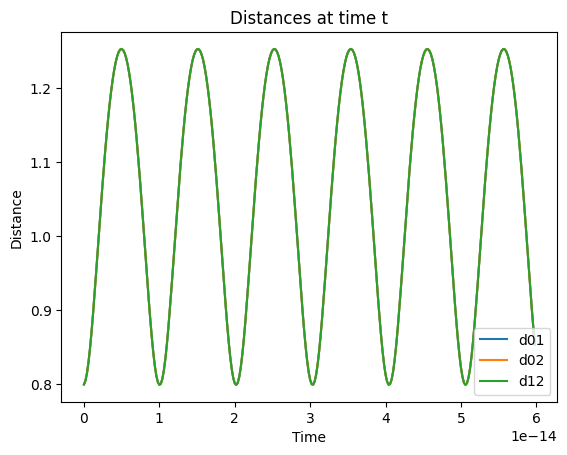

In [14]:
np_distance01 = np.array(distance01)
np_distance02 = np.array(distance02)
np_distance12 = np.array(distance12)

all_traces = np.stack((times,np_distance01[1:],np_distance02[1:],np_distance12[1:]))
np.save('h3_diagonal_10shots_delta=8dt',all_traces)

plt.plot(times,np_distance01[:-1],label = 'd01')
plt.plot(times,np_distance02[:-1],label = 'd02')
plt.plot(times,np_distance12[:-1],label = 'd12')
plt.title('Distances at time t')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.show()